## Strunt and Tie generation using Sofistik

### I. Connection to the CDB

Use Sofistik library : https://docs.sofistik.com/2024/en/cdb_interfaces/python/examples/python_example1.html

In [1]:
import os               # for the environment variable necessary, this is a great tool
import platform         # checks the python platform
import string
from ctypes import *    # read the functions from the cdb

# Set DLL dir path
os.add_dll_directory(r"C:\Program Files\SOFiSTiK\2024\SOFiSTiK 2024\interfaces\64bit")
os.add_dll_directory(r"C:\Program Files\SOFiSTiK\2024\SOFiSTiK 2024")

# Get the DLL functions
myDLL = cdll.LoadLibrary("sof_cdb_w-2024.dll")
py_sof_cdb_get = cdll.LoadLibrary("sof_cdb_w-2024.dll").sof_cdb_get
py_sof_cdb_get.restype = c_int
py_sof_cdb_kenq = cdll.LoadLibrary("sof_cdb_w-2024.dll").sof_cdb_kenq_ex

def open_cdb(fileName):

    # Connect to CDB
    Index = c_int()
    cdbIndex = 99

    # important: Unicode call!
    Index.value = myDLL.sof_cdb_init(fileName.encode('utf8'), cdbIndex)

    # get the CDB status
    cdbStat = c_int()
    cdbStat.value = myDLL.sof_cdb_status(Index.value)

    # Print the Status of the CDB
    print ("CDB opened successfully, CDB Status =", cdbStat.value)

    return cdbStat, Index

def close_cdb(cdbStat, Index):

    myDLL = cdll.LoadLibrary("sof_cdb_w-2024.dll")
    # Close the CDB, 0 - will close all the files
    myDLL.sof_cdb_close(0)
    
    # Print again the status of the CDB, if status = 0 -> CDB Closed successfully
    cdbStat.value = myDLL.sof_cdb_status(Index.value)
    if cdbStat.value == 0:
        print ("CDB closed successfully, CDB Status = 0")

fileName=r"C:\Users\Utilisateur\OneDrive - Pini Group\SOFISTIK\b.cdb"

cdbStat, Index=open_cdb(fileName) 
close_cdb(cdbStat, Index)
    

CDB opened successfully, CDB Status = 3
CDB closed successfully, CDB Status = 0


<span style="background-color: darkred; font-size:24px;">cdbStat</span> : C'est une variable qui sert à vérifier le statut de chaque opération sur la base de données. Elle est utile pour s'assurer que chaque étape (ouverture, fermeture, lecture) s'est déroulée correctement, et elle permet de diagnostiquer les erreurs éventuelles.

<span style="background-color: darkred;font-size:24px;">Index</span> : C'est un identifiant unique qui permet de manipuler la base de données CDB tout au long du programme. Il est utilisé pour garder une trace de la connexion à la CDB et est nécessaire pour les opérations de lecture et d'écriture.

In [2]:
from sofistik_daten import *

def node_properties(Index):
   pos = c_int(0)
   datalen = c_int(0)

   a = c_int()
   ie = c_int(0)
   datalen.value = sizeof(CNODE)
   RecLen = c_int(sizeof(cnode))

   """
   do while ie == 0, see cdbase.chm, Returnvalue.
      = 0 -> No error
      = 1 -> Item is longer than Data
      = 2 -> End of file reached
      = 3 -> Key does not exist
   """
   while ie.value < 2:
      ie.value = py_sof_cdb_get(Index, 20, 0, byref(cnode), byref(RecLen), 1)
      print("{:10d}{:10d}{:10d}{:10d}{:10.2f}{:10.2f}{:10.2f}".format(
         cnode.m_nr,      # node-number
         cnode.m_inr,     # internal node-number
         cnode.m_kfix,    # degree of freedoms
         cnode.m_ncod,    # additional bit code
         cnode.m_xyz[0],  # x coordinates
         cnode.m_xyz[1],  # y coordinates
         cnode.m_xyz[2])  # z coordinates
      )

      # Always read the length of record before sof_cdb_get is called
      RecLen = c_int(sizeof(cnode))

fileName=r"C:\Users\Utilisateur\OneDrive - Pini Group\SOFISTIK\b.cdb"
cdbStat, Index=open_cdb(fileName)

node_properties(Index)
close_cdb(cdbStat,Index)

CDB opened successfully, CDB Status = 3
         1         1         0       259      0.20      0.00      0.00
         2         2         0       515      4.81      0.00      0.00
      1001         3      1571    256259      0.00      0.00      0.00
      1002         4      1571    256515      5.00      0.00      0.00
      1003         5      1571    256771      5.00      2.00      0.00
      1004         6      1571    257027      0.00      2.00      0.00
      1005         7      1571    256322      0.10      0.00      0.00
      1006         8      1571    256578      5.00      0.11      0.00
      1007         9      1571    256578      5.00      0.21      0.00
      1008        10      1571    256578      5.00      0.35      0.00
      1009        11      1571    256578      5.00      0.48      0.00
      1010        12      1571    256578      5.00      0.65      0.00
      1011        13      1571    256578      5.00      0.82      0.00
      1012        14      1571    256

### II. Accéder aux contraintes

In [3]:
from sofistik_daten import *

# Function to read nodal forces using CN_DISP structure
def node_forces(Index):
    ie = c_int(0)
    RecLen = c_int(sizeof(CN_DISP))  # Size of the displacement and forces structure
    disp = CN_DISP()  # Instance of the displacement and forces structure

    """
    do while ie == 0, see cdbase.chm, Returnvalue.
       = 0 -> No error
       = 1 -> Item is longer than Data
       = 2 -> End of file reached
       = 3 -> Key does not exist
    """
    while ie.value < 2:
        ie.value = py_sof_cdb_get(Index, 24, 1, byref(disp), byref(RecLen), 1)
        print("{:10d}{:10.2f}{:10.2f}{:10.2f}{:10.2f}{:10.2f}{:10.2f}{:10.2f}{:10.2f}{:10.2f}{:10.2f}{:10.2f}{:10.2f}{:10.2f}{:10.2f}".format(
            disp.m_nr,      # node number
            disp.m_ux,      # displacement
            disp.m_uy,      # displacement
            disp.m_uz,      # displacement
            disp.m_urx,     # rotation
            disp.m_ury,     # rotation
            disp.m_urz,     # rotation
            disp.m_urb,     # [1005] twisting
            disp.m_px,      # [1151] nodal support
            disp.m_py,      # [1151] nodal support
            disp.m_pz,      # [1151] nodal support
            disp.m_mx,      # [1152] support moment
            disp.m_my,      # [1152] support moment
            disp.m_mz,      # [1152] support moment
            disp.m_mb       # [1105] warping moment
        ))

        # Always read the length of record before sof_cdb_get is called
        RecLen = c_int(sizeof(CN_DISP))

fileName=r"C:\Users\Utilisateur\OneDrive - Pini Group\SOFISTIK\b.cdb"
cdbStat, Index=open_cdb(fileName)

node_forces(Index)
close_cdb(cdbStat,Index)

CDB opened successfully, CDB Status = 3
         0      0.00      0.00      0.00      0.00      0.00      0.00      0.00     19.01     41.30      0.00      0.00      0.00      0.00      0.00
         0     -0.00     -0.00      0.00      0.00      0.00     -0.00      0.00    -19.01      0.00      0.00      0.00      0.00      0.00      0.00
         1      0.00      0.00      0.00      0.00      0.00      0.00      0.00     19.01     41.30      0.00      0.00      0.00      0.00      0.00
         2      0.00      0.00      0.00      0.00      0.00      0.00      0.00    -19.01     41.20      0.00      0.00      0.00      0.00      0.00
      1001     -0.00     -0.00      0.00      0.00      0.00      0.00      0.00    -19.01     41.20      0.00      0.00      0.00      0.00      0.00
      1002      0.00     -0.00      0.00      0.00      0.00     -0.00      0.00    -19.01     41.20      0.00      0.00      0.00      0.00      0.00
      1003     -0.00     -0.00      0.00      0.00    

In [4]:
from sofistik_daten import *

# Function to read nodal forces using CN_DISP structure
def quad_forces(Index):
    ie = c_int(0)
    RecLen = c_int(sizeof(CQUAD_FOR))  # Size of the displacement and forces structure
    forces = CQUAD_FOR()  # Instance of the displacement and forces structure

    """
    do while ie == 0, see cdbase.chm, Returnvalue.
       = 0 -> No error
       = 1 -> Item is longer than Data
       = 2 -> End of file reached
       = 3 -> Key does not exist
    """
    while ie.value < 2:
        ie.value = py_sof_cdb_get(Index, 210, 1, byref(forces), byref(RecLen), 1)
        print("{:10d}{:10.2f}{:10.2f}{:10.2f}{:10.2f}{:10.2f}{:10.2f}{:10.2f}{:10.2f}".format(
            forces.m_nr,      # quad number
            forces.m_mxx,      # bending moment
            forces.m_myy,
            forces.m_mxy,
            forces.m_vx,        #shear force
            forces.m_vy,
            forces.m_nx,        #membran force
            forces.m_ny,
            forces.m_nxy
        ))
        # Always read the length of record before sof_cdb_get is called
        RecLen = c_int(sizeof(CQUAD_FOR))

fileName=r"C:\Users\Utilisateur\OneDrive - Pini Group\SOFISTIK\b.cdb"
cdbStat, Index=open_cdb(fileName)

quad_forces(Index)
close_cdb(cdbStat,Index)

CDB opened successfully, CDB Status = 3
         0      0.00      0.00      0.00      0.00      0.00     41.61     55.75    206.79
         0      0.00      0.00      0.00      0.00      0.00   -369.18   -404.83   -194.84
     20001      0.00      0.00      0.00      0.00      0.00     -5.89    -19.54    -22.78
     20002      0.00      0.00      0.00      0.00      0.00     -2.87    -31.32    -23.62
     20003      0.00      0.00      0.00      0.00      0.00     -1.25    -32.18    -17.24
     20004      0.00      0.00      0.00      0.00      0.00     -3.72    -22.49    -19.17
     20005      0.00      0.00      0.00      0.00      0.00     33.64      0.07      1.88
     20006      0.00      0.00      0.00      0.00      0.00     35.46      0.44      0.72
     20007      0.00      0.00      0.00      0.00      0.00     16.94     -0.52      2.06
     20008      0.00      0.00      0.00      0.00      0.00     17.46     -0.03      5.10
     20009      0.00      0.00      0.00      0.00

In [5]:
from sofistik_daten import *
from ctypes import c_int, sizeof, byref
import pandas as pd


# Function to read nodal forces using CN_DISP structure and store in a list
def quad_forces(Index):
    ie = c_int(0)
    RecLen = c_int(sizeof(CQUAD_FOR))  # Size of the displacement and forces structure
    forces = CQUAD_FOR()  # Instance of the displacement and forces structure
    forces_data = []  # List to store forces for each element

    while ie.value < 2:
        ie.value = py_sof_cdb_get(Index, 210, 1, byref(forces), byref(RecLen), 1)

        if ie.value == 0:  # No error, data was read
            forces_data.append({
                "quad_number": forces.m_nr,   # Quad number
                "mxx": forces.m_mxx,          # Bending moment mxx
                "myy": forces.m_myy,          # Bending moment myy
                "mxy": forces.m_mxy,          # Bending moment mxy
                "vx": forces.m_vx,            # Shear force vx
                "vy": forces.m_vy,            # Shear force vy
                "nx": forces.m_nx,            # Membrane force nx
                "ny": forces.m_ny,            # Membrane force ny
                "nxy": forces.m_nxy           # Membrane force nxy
            })
        
        # Always reset RecLen before the next sof_cdb_get call
        RecLen = c_int(sizeof(CQUAD_FOR))

    return forces_data  # Return the list with all the forces data

# Example of usage
fileName = r"C:\Users\Utilisateur\OneDrive - Pini Group\SOFISTIK\b.cdb"
cdbStat, Index = open_cdb(fileName)

forces_list = quad_forces(Index)
close_cdb(cdbStat, Index)


# Convert the list to a Pandas DataFrame
df_forces = pd.DataFrame(forces_list)

CDB opened successfully, CDB Status = 3
CDB closed successfully, CDB Status = 0


In [6]:
# Convert the list to a Pandas DataFrame
df_forces = pd.DataFrame(forces_list)

In [7]:
df_forces

,quad_number,mxx,myy,mxy,vx,vy,nx,ny,nxy
0,0,0.0,0.0,0.0,0.0,0.0,41.606667,55.749775,206.790283
1,0,0.0,0.0,0.0,0.0,0.0,-369.184265,-404.832825,-194.841293
2,20001,0.0,0.0,0.0,0.0,0.0,-5.888048,-19.540747,-22.777464
3,20002,0.0,0.0,0.0,0.0,0.0,-2.871248,-31.321043,-23.620758
4,20003,0.0,0.0,0.0,0.0,0.0,-1.245961,-32.178619,-17.236378
...,...,...,...,...,...,...,...,...,...
287,20286,0.0,0.0,0.0,0.0,0.0,-3.715370,-7.800370,7.062850
288,20287,0.0,0.0,0.0,0.0,0.0,-6.273705,-5.901103,7.507652
289,20288,0.0,0.0,0.0,0.0,0.0,-2.582406,-26.801802,19.760466
290,20289,0.0,0.0,0.0,0.0,0.0,-2.137352,-23.699650,15.294311


In [8]:
df_membran_forces=df_forces[['quad_number', 'nx', 'ny', 'nxy']]
df_membran_forces

,quad_number,nx,ny,nxy
0,0,41.606667,55.749775,206.790283
1,0,-369.184265,-404.832825,-194.841293
2,20001,-5.888048,-19.540747,-22.777464
3,20002,-2.871248,-31.321043,-23.620758
4,20003,-1.245961,-32.178619,-17.236378
...,...,...,...,...
287,20286,-3.715370,-7.800370,7.062850
288,20287,-6.273705,-5.901103,7.507652
289,20288,-2.582406,-26.801802,19.760466
290,20289,-2.137352,-23.699650,15.294311


CDB opened successfully, CDB Status = 3
CDB closed successfully, CDB Status = 0


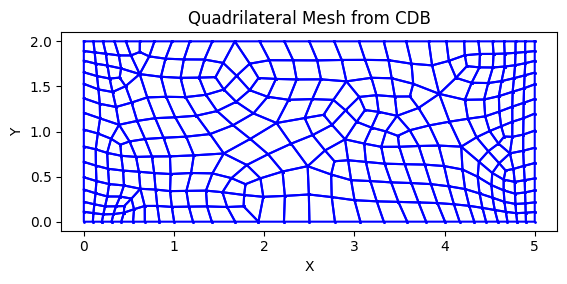

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from ctypes import c_int, sizeof, byref
from sofistik_daten import *  # Importer vos fonctions SOFiSTiK

# Fonction pour extraire les coordonnées des nœuds depuis la base de données CDB
def extract_node_coords(Index):
    ie = c_int(0)
    RecLen = c_int(sizeof(CNODE))  # Taille de la structure CNODE
    node = CNODE()  # Instance de la structure CNODE
    node_coords = {}  # Dictionnaire pour stocker les coordonnées des nœuds

    while ie.value < 2:
        ie.value = py_sof_cdb_get(Index, 20, 0, byref(node), byref(RecLen), 1)  # Lire les nœuds depuis CDB
        if ie.value == 0:  # Pas d'erreur, nœud lu correctement
            node_coords[node.m_nr] = (node.m_xyz[0], node.m_xyz[1])  # Stocker les coordonnées X et Y du nœud
        RecLen = c_int(sizeof(CNODE))  # Réinitialiser la taille de l'enregistrement
    return node_coords  # Retourner les coordonnées des nœuds

# Fonction pour extraire les éléments quadrilatéraux (avec les nœuds associés)
def extract_quad_elements(Index):
    ie = c_int(0)
    RecLen = c_int(sizeof(CQUAD))  # Taille de la structure CQUAD
    quad_element = CQUAD()  # Instance de la structure CQUAD
    elements = []  # Liste pour stocker les éléments quadrilatéraux

    while ie.value < 2:
        ie.value = py_sof_cdb_get(Index, 200, 0, byref(quad_element), byref(RecLen), 1)  # Lire les éléments quadrilatéraux
        if ie.value == 0:  # Pas d'erreur, élément lu correctement
            elements.append(quad_element.m_node[:])  # Ajouter les 4 nœuds de l'élément dans la liste
        RecLen = c_int(sizeof(CQUAD))  # Réinitialiser la taille de l'enregistrement

    return elements  # Retourner les éléments quadrilatéraux

# Fonction pour créer et afficher le maillage quadrilatéral
def plot_quad_mesh_from_cdb(file_path):
    # Ouverture de la base de données CDB
    cdbStat, Index = open_cdb(file_path)

    # Extraction des coordonnées des nœuds
    node_coords = extract_node_coords(Index)

    # Extraction des éléments quadrilatéraux
    elements = extract_quad_elements(Index)

    # Fermeture de la base de données CDB
    close_cdb(cdbStat, Index)

    # Affichage du maillage
    fig, ax = plt.subplots()

    for element in elements:
        # Récupérer les coordonnées des nœuds de l'élément
        quad_coords = np.array([node_coords[node] for node in element])
        # Boucler pour revenir au premier nœud afin de fermer le quadrilatère
        quad_coords = np.vstack([quad_coords, quad_coords[0]])  # Fermer le quadrilatère
        ax.plot(quad_coords[:, 0], quad_coords[:, 1], 'b-o',markersize=1)  # Tracer l'élément quadrilatère

    ax.set_aspect('equal')
    plt.title("Quadrilateral Mesh from CDB")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(False)
    plt.show()

# Exemple d'utilisation
file_path = r"C:\Users\Utilisateur\OneDrive - Pini Group\SOFISTIK\b.cdb"
plot_quad_mesh_from_cdb(file_path)


In [10]:
extract_node_coords(Index)

{}

In [11]:
# Fonction pour calculer le centre d'un quadrilatère
def calculate_quad_centers(node_coords, elements):
    centers = []
    for element in elements:
        # Extraire les coordonnées des nœuds de l'élément
        quad_coords = np.array([node_coords[node] for node in element])
        # Calculer le centre du quadrilatère en prenant la moyenne des coordonnées
        center = np.mean(quad_coords, axis=0)
        centers.append(center)
    return centers

In [14]:
import plotly.graph_objects as go
# Fonction pour afficher un graphique interactif avec Plotly
def plot_quad_mesh_with_plotly(file_path, df_membran_forces):
    # Ouverture de la base de données CDB
    cdbStat, Index = open_cdb(file_path)

    # Extraction des coordonnées des nœuds
    node_coords = extract_node_coords(Index)

    # Extraction des éléments quadrilatéraux
    elements = extract_quad_elements(Index)

    # Fermeture de la base de données CDB
    close_cdb(cdbStat, Index)

    # Calcul des centres des éléments quadrilatéraux
    centers = calculate_quad_centers(node_coords, elements)

    # Création d'une figure plotly
    fig = go.Figure()

    # Tracer le maillage sans valeurs
    for element in elements:
        quad_coords = np.array([node_coords[node] for node in element])
        quad_coords = np.vstack([quad_coords, quad_coords[0]])  # Fermer le quadrilatère
        x_coords = quad_coords[:, 0]
        y_coords = quad_coords[:, 1]

        # Ajout du quadrilatère au graphique
        fig.add_trace(go.Scatter(
            x=x_coords, y=y_coords, mode='lines',
            line=dict(color='black', width=1),
            showlegend=False
        ))

    # Affichage des valeurs de nx au centre de chaque quadrilatère
    for i, center in enumerate(centers):
        nx_value = df_membran_forces.loc[i, 'nx']

        # Déterminer la couleur : rouge pour négatif, bleu pour positif
        color = 'red' if nx_value < 0 else 'blue'

        # Ajouter la valeur de nx comme annotation
        fig.add_trace(go.Scatter(
            x=[center[0]], y=[center[1]],
            text=[f'{nx_value:.2f}'],
            mode='text',
            textfont=dict(color=color, size=12)
        ))

    # Configuration du layout pour interactivité
    fig.update_layout(
        title="nx Values on Quadrilateral Mesh (Interactive)",
        xaxis_title="X",
        yaxis_title="Y",
        xaxis=dict(scaleanchor="y", scaleratio=1),  # Forcing equal scaling
        yaxis=dict(scaleanchor="x", scaleratio=1),
        showlegend=False,
        autosize=True,
    )

    # Affichage interactif
    fig.show()

In [16]:
# Appel de la fonction avec le fichier CDB et les forces membranaires
file_path = r"C:\Users\Utilisateur\OneDrive - Pini Group\SOFISTIK\b.cdb"
plot_quad_mesh_with_plotly(file_path, df_membran_forces)

CDB opened successfully, CDB Status = 3
CDB closed successfully, CDB Status = 0
